# Library Imports

In [3]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np
from datetime import datetime
import os
import csv

# API and Network Requests
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from time import sleep

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Network Analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go

# Type Hints
from typing import List, Dict, Tuple, Optional

## Look for Fresh Data from Liked Artists

In [4]:
class LastFMAPI:
    def __init__(self, api_key: str, username: str, rate_limit_delay: float = 0.25):
        self.api_key = api_key
        self.username = username
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.rate_limit_delay = rate_limit_delay
        
    def _make_request(self, params: dict) -> dict:
        sleep(self.rate_limit_delay)
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"API request failed for {params.get('artist')}: {e}")
            return None

    def get_similar_artists(self, artist_name: str, limit: int = 5) -> List[str]:
        params = {
            'method': 'artist.getsimilar',
            'artist': artist_name,
            'api_key': self.api_key,
            'format': 'json',
            'limit': limit
        }
        data = self._make_request(params)
        if data and 'similarartists' in data:
            return [artist['name'] for artist in data['similarartists'].get('artist', [])]
        return []

def export_similar_artists(api_key: str, username: str, output_file: str = 'data/liked_artists_only_similar.csv'):
    df_liked = pd.read_csv('data/liked.csv')
    df_liked_albums = pd.read_csv('data/liked_albums.csv')
    
    df_liked['Artist'] = df_liked['Artist Name(s)'].str.split(',').str[0].str.strip()
    df_liked_albums['Artist'] = df_liked_albums['Artist Name(s)'].str.split(',').str[0].str.strip()
    
    unique_artists = set(pd.concat([df_liked['Artist'], df_liked_albums['Artist']]).unique())
    
    existing_artists = set()
    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
        existing_artists = set(existing_df['Artist'].str.strip())
    
    new_artists = list(unique_artists - existing_artists)
    
    if not new_artists:
        print("No new artists found. Skipping API calls.")
        return
        
    if len(new_artists) <= 30:
        print("New artists to process:")
        for artist in new_artists:
            print(f"- {artist}")
    else:
        print(f"Processing {len(new_artists)} new artists...")
    
    api = LastFMAPI(api_key, username)
    processed_count = 0
    
    mode = 'a' if os.path.exists(output_file) else 'w'
    with open(output_file, mode, newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['Artist', 'Similar Artists'])
        if mode == 'w':
            writer.writeheader()
            
        for artist in new_artists:
            similar_artists = api.get_similar_artists(artist)
            writer.writerow({
                'Artist': artist,
                'Similar Artists': ', '.join(similar_artists)
            })
            processed_count += 1
            
            if len(new_artists) > 30 and processed_count % 50 == 0:
                print(f"Processed {processed_count} artists...")
    
    print(f"Complete! Added {len(new_artists)} new artists to the database.")

if __name__ == "__main__":
    API_KEY = '74a510ecc9fc62bf3e0edc6adc2e99f9'
    USERNAME = 'Strusz_Music'
    export_similar_artists(API_KEY, USERNAME)

Processing 1873 new artists...
Processed 50 artists...
Processed 100 artists...
Processed 150 artists...
Processed 200 artists...
Processed 250 artists...
Processed 300 artists...
Processed 350 artists...
Processed 400 artists...
Processed 450 artists...
Processed 500 artists...
Processed 550 artists...
Processed 600 artists...
Processed 650 artists...
Processed 700 artists...
Processed 750 artists...
Processed 800 artists...
Processed 850 artists...
Processed 900 artists...
Processed 950 artists...
Processed 1000 artists...
Processed 1050 artists...
Processed 1100 artists...
Processed 1150 artists...
Processed 1200 artists...
Processed 1250 artists...
Processed 1300 artists...
Processed 1350 artists...
Processed 1400 artists...
Processed 1450 artists...
Processed 1500 artists...
Processed 1550 artists...
Processed 1600 artists...
Processed 1650 artists...
Processed 1700 artists...
Processed 1750 artists...
Processed 1800 artists...
Processed 1850 artists...
Complete! Added 1873 new ar

## Look for Fresh Similar Artists to NMF Artists

In [6]:
class LastFMAPI:
    def __init__(self, api_key: str, username: str, rate_limit_delay: float = 0.25):
        self.api_key = api_key
        self.username = username
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.rate_limit_delay = rate_limit_delay
        
    def _make_request(self, params: dict) -> dict:
        sleep(self.rate_limit_delay)
        try:
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"API request failed for {params.get('artist')}: {e}")
            return None

    def get_similar_artists(self, artist_name: str, limit: int = 5) -> List[str]:
        params = {
            'method': 'artist.getsimilar',
            'artist': artist_name,
            'api_key': self.api_key,
            'format': 'json',
            'limit': limit
        }
        data = self._make_request(params)
        if data and 'similarartists' in data:
            return [artist['name'] for artist in data['similarartists'].get('artist', [])]
        return []

def export_similar_artists(api_key: str, username: str, output_file: str = 'data/nmf_artist_adjacent.csv'):
    # Read the NMF file
    df_nmf = pd.read_csv('data/nmf.csv')
    
    # Extract first artist from comma-separated list, just like in original code
    df_nmf['Artist'] = df_nmf['Artist Name(s)'].str.split(',').str[0].str.strip()
    
    # Get unique artists
    unique_artists = set(df_nmf['Artist'].unique())
    
    # Check for existing artists in the adjacent file
    existing_artists = set()
    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
        existing_artists = set(existing_df['Artist'].str.strip())
    
    # Find artists that need to be processed
    new_artists = list(unique_artists - existing_artists)
    
    if not new_artists:
        print("No new artists found. Skipping API calls.")
        return
        
    # Print progress information
    if len(new_artists) <= 30:
        print("New artists to process:")
        for artist in new_artists:
            print(f"- {artist}")
    else:
        print(f"Processing {len(new_artists)} new artists...")
    
    # Process new artists
    api = LastFMAPI(api_key, username)
    processed_count = 0
    
    mode = 'a' if os.path.exists(output_file) else 'w'
    with open(output_file, mode, newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=['Artist', 'Similar Artists'])
        if mode == 'w':
            writer.writeheader()
            
        for artist in new_artists:
            similar_artists = api.get_similar_artists(artist)
            writer.writerow({
                'Artist': artist,
                'Similar Artists': ', '.join(similar_artists)
            })
            processed_count += 1
            
            if len(new_artists) > 30 and processed_count % 50 == 0:
                print(f"Processed {processed_count} artists...")
    
    print(f"Complete! Added {len(new_artists)} new artists to the database.")

if __name__ == "__main__":
    API_KEY = '74a510ecc9fc62bf3e0edc6adc2e99f9'
    USERNAME = 'Strusz_Music'
    export_similar_artists(API_KEY, USERNAME)

No new artists found. Skipping API calls.


# Load Datasets

In [8]:
df_liked = pd.read_csv("data/liked.csv") #Liked playlist on Spotify
df_fav_albums = pd.read_csv("data/liked_albums.csv") #Albums I've Liked in Recent Years
df_not_liked = pd.read_csv("data/did_not_like.csv") #Albums I've not liked in Recent Years
df_nmf = pd.read_csv("data/nmf.csv") #The most recent New Music Friday Playlist
df_liked_similar = pd.read_csv("data/liked_artists_only_similar.csv") #Lastfm pull of similar artists my recently played artists
df_nmf_similar = pd.read_csv("data/nmf_artist_adjacent.csv") #Lastfm pull of similar artists to this weeks NMF artists

In [9]:
df_liked.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,5FfGYE5eTM2K1Si4ucy2XC,Monuments & Bricks,Poison,CATHEDRALE,2025-02-14,243029,0,NaN,2025-02-15T22:44:31Z,post-punk,...,9,-7.327,1,0.0322,0.000036,0.003600,0.264,0.234,137.635,4
1,6J1qJGfbB31D0WxiehfcoV,Did You Lose Your Heart,Out Of The Blue,Morgan Saint,2025-02-14,244143,0,NaN,2025-02-15T19:50:54Z,NaN,...,0,-7.904,1,0.0367,0.360000,0.007430,0.115,0.914,94.995,4
2,5Iel8B8LQe12lEofB20OTp,Over and Over,Heartache in Room 14,The Altons,2025-02-14,228933,1,NaN,2025-02-15T18:46:58Z,retro soul,...,6,-6.220,1,0.0261,0.780000,0.000021,0.162,0.260,115.136,3
3,5sZ5AyRhjKSYAh7vqNJXuH,Victory Lap,Victory Lap,Valley Palace,2022-11-29,187629,24,NaN,2025-02-12T16:12:28Z,dream pop,...,2,-6.695,1,0.0283,0.024000,0.658000,0.262,0.590,152.014,4
4,2EEinN4Zk8MUv4OQuLsTBj,Age of Consent - 2015 Remaster,Power Corruption and Lies,New Order,1983-05-02,315333,61,NaN,2025-02-12T16:03:41Z,"new wave,synthpop,post-punk,madchester",...,2,-5.559,1,0.0392,0.001010,0.094400,0.130,0.756,161.964,4


In [10]:
# Liked Albums in Recent Years
df_fav_albums.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,0UOeq7bSskoJa4cJaJOmFS,Ticking,Letter to Self,SPRINTS,2024-01-05,186949,31,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,11.0,-6.490,1.0,0.3440,0.02500,0.076500,0.0934,0.291,175.574,4.0
1,02bA26OEe0nNFyE3YcNx4K,Heavy,Letter to Self,SPRINTS,2024-01-05,207409,46,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,11.0,-5.925,1.0,0.0591,0.00435,0.000738,0.0877,0.189,88.581,4.0
2,7IPDhCIQlpvxVxtC1Q7Jq4,Cathedral,Letter to Self,SPRINTS,2024-01-05,179694,30,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,7.0,-6.231,1.0,0.0473,0.00978,0.002700,0.0887,0.397,119.056,4.0
3,65fPteG9ctHt2rrJxlbMr8,Shaking Their Hands,Letter to Self,SPRINTS,2024-01-05,222489,28,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,4.0,-5.658,0.0,0.0533,0.19900,0.108000,0.1330,0.551,89.485,4.0
4,4UgkFdXpJD0fhw06BMk0bz,Adore Adore Adore,Letter to Self,SPRINTS,2024-01-05,157766,36,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T00:53:10Z,post-punk,...,4.0,-4.401,0.0,0.2570,0.01070,0.000107,0.1010,0.402,176.054,4.0


In [11]:
# Albums Not Liked in Recent Years
df_not_liked.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,54KEm0VI9i3ic7VHHKHKRx,¿Cómo Así?,ORQUÍDEAS,Kali Uchis,2024-01-12,169654,56,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,6.0,-7.662,0.0,0.0892,0.04170,0.346000,0.154,0.379,135.985,4.0
1,5mVkTPlTPxlQOn7kEvuM3j,Me Pongo Loca,ORQUÍDEAS,Kali Uchis,2024-01-12,177815,53,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,7.0,-8.680,0.0,0.0426,0.03710,0.152000,0.106,0.407,114.999,4.0
2,6XaJfhwof7qIgbbXO5tIQI,Igual Que Un Ángel (with Peso Pluma),ORQUÍDEAS,"Kali Uchis,Peso Pluma",2024-01-12,260370,75,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,"corrido,corridos tumbados,corridos bélicos,mús...",...,5.0,-5.340,0.0,0.0320,0.00449,0.000663,0.185,0.482,108.001,4.0
3,52x8HIGuk1gGTlvO8CuLNS,Pensamientos Intrusivos,ORQUÍDEAS,Kali Uchis,2024-01-12,192027,60,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,9.0,-8.333,0.0,0.0394,0.57500,0.012900,0.110,0.511,119.994,4.0
4,3RleMgz4iO0BNezGdSxDnY,Diosa,ORQUÍDEAS,Kali Uchis,2024-01-12,156037,58,mmr4r23xnc6oh1c77lysfbqg4,2025-01-29T01:04:15Z,NaN,...,5.0,-5.518,0.0,0.0668,0.06750,0.000101,0.078,0.698,107.994,4.0


In [12]:
# New Music Friday Playlist
df_nmf.head()

,Track ID,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,Genres,...,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
0,3y0DIcBw075qzj3dOwJ5aL,From The Gods,Food From the Gods,"Black Milk,Fat Ray",2025-02-13,88678,20,jaytroymo,2025-02-14T06:13:23Z,"alternative hip hop,underground hip hop",...,9.0,-8.414,0.0,0.408,0.449,0.118000,0.3760,0.559,89.450,3.0
1,6TR2jKnq9yFwk3oqKUTnWp,ELDERBERRY,Food From the Gods,"Black Milk,Fat Ray",2025-02-13,189000,20,jaytroymo,2025-02-14T06:13:23Z,"alternative hip hop,underground hip hop",...,2.0,-7.407,1.0,0.347,0.454,0.004310,0.0916,0.634,81.092,4.0
2,6UC2W5IR7lx3BQGsWf4qD3,Talcum,Food From the Gods,"Black Milk,Fat Ray",2025-02-13,156144,19,jaytroymo,2025-02-14T06:13:23Z,"alternative hip hop,underground hip hop",...,11.0,-6.015,0.0,0.240,0.660,0.000005,0.2150,0.628,79.591,4.0
3,7HSjLESxFyDRrmq6AdGkJh,CANE,Food From the Gods,"Black Milk,Fat Ray,Guilty Simpson",2025-02-13,149010,19,jaytroymo,2025-02-14T06:13:23Z,"alternative hip hop,underground hip hop,boom bap",...,8.0,-6.045,1.0,0.280,0.219,0.000000,0.4430,0.719,90.831,4.0
4,1XZqPCN9JU3xtnS0aC72UC,Just Say No,Food From the Gods,"Black Milk,Fat Ray,Danny Brown",2025-02-13,201276,19,jaytroymo,2025-02-14T06:13:23Z,"alternative hip hop,underground hip hop,experi...",...,4.0,-8.114,0.0,0.206,0.737,0.261000,0.3630,0.907,90.020,4.0


In [13]:
# Similar Artists to Recently Played Artists (Last.fm)
df_liked_similar.head()

,Artist,Similar Artists
0,CATHEDRALE,NaN
1,New Order,"Joy Division, Electronic, The Other Two, Orche..."
2,Valley Palace,"Cool Heat, Lunar Isles, Sea Lemon, Castlebeat,..."
3,The Altons,"Thee Sinseers, Joey Quinones, Jason Joshua & T..."
4,Morgan Saint,"Milk & Bone, Luna Shadows, Wafia, Ella Vos, Tr..."


In [14]:
# Similar Artists to NMF Artists (Last.fm)
df_nmf_similar.head()

,Artist,Similar Artists
0,Rats On Rafts,"The Homesick, Nouveau Velo, Bombay Show Pig, N..."
1,Adwaith,"Buzzard Buzzard Buzzard, Melin Melyn, Gorky's ..."
2,"""Swept Away Original Broadway Cast,The Avett B...",NaN
3,Krept & Konan,"Cadet, Giggs, Abra Cadabra, Yxng Bane, Kojo Funds"
4,Shannon Wright,"Elysian Fields, Scout Niblett, Kristin Hersh, ..."


> A quick reminder of the standard columns of a spotify export.

In [16]:
df_liked.columns

Index(['Track ID', 'Track Name', 'Album Name', 'Artist Name(s)',
       'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At',
       'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Time Signature'],
      dtype='object')

In [17]:
df_liked_similar.columns

Index(['Artist', 'Similar Artists'], dtype='object')

In [18]:
df_nmf_similar.columns

Index(['Artist', 'Similar Artists'], dtype='object')

### Add Target Labels for Training Feature

In [20]:
# Assign liked scores before combining
df_liked['liked'] = 100
df_fav_albums['liked'] = 50
df_not_liked['liked'] = 0
df_nmf['liked'] = np.nan 

# Add playlist_origin column before combining
df_liked['playlist_origin'] = 'df_liked'
df_fav_albums['playlist_origin'] = 'df_fav_albums'
df_not_liked['playlist_origin'] = 'df_not_liked'
df_nmf['playlist_origin'] = 'df_nmf'
df_liked_similar['source'] = 'liked_similar'
df_nmf_similar['source'] = 'nmf_similar'

### Check application of the target encoding

In [22]:
df_liked[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,100,df_liked
1,100,df_liked
2,100,df_liked
3,100,df_liked
4,100,df_liked


In [23]:
df_fav_albums[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,50,df_fav_albums
1,50,df_fav_albums
2,50,df_fav_albums
3,50,df_fav_albums
4,50,df_fav_albums


In [24]:
df_not_liked[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,0,df_not_liked
1,0,df_not_liked
2,0,df_not_liked
3,0,df_not_liked
4,0,df_not_liked


In [25]:
df_nmf[['liked', 'playlist_origin']].head()

,liked,playlist_origin
0,NaN,df_nmf
1,NaN,df_nmf
2,NaN,df_nmf
3,NaN,df_nmf
4,NaN,df_nmf


In [26]:
df_liked_similar[['Artist', 'Similar Artists', 'source']].head()

,Artist,Similar Artists,source
0,CATHEDRALE,NaN,liked_similar
1,New Order,"Joy Division, Electronic, The Other Two, Orche...",liked_similar
2,Valley Palace,"Cool Heat, Lunar Isles, Sea Lemon, Castlebeat,...",liked_similar
3,The Altons,"Thee Sinseers, Joey Quinones, Jason Joshua & T...",liked_similar
4,Morgan Saint,"Milk & Bone, Luna Shadows, Wafia, Ella Vos, Tr...",liked_similar


In [27]:
df_nmf_similar[['Artist', 'Similar Artists', 'source']].head()

,Artist,Similar Artists,source
0,Rats On Rafts,"The Homesick, Nouveau Velo, Bombay Show Pig, N...",nmf_similar
1,Adwaith,"Buzzard Buzzard Buzzard, Melin Melyn, Gorky's ...",nmf_similar
2,"""Swept Away Original Broadway Cast,The Avett B...",NaN,nmf_similar
3,Krept & Konan,"Cadet, Giggs, Abra Cadabra, Yxng Bane, Kojo Funds",nmf_similar
4,Shannon Wright,"Elysian Fields, Scout Niblett, Kristin Hersh, ...",nmf_similar


## Merge The Datasets

In [29]:
df = pd.concat([df_liked, df_fav_albums, df_not_liked, df_nmf], ignore_index=True)

In [30]:
#How Large is the Dataset, Now?
df.shape

(13307, 25)

#### Remove the Duplicates

In [32]:
# Remove duplicates: Keep the highest 'liked' score (100 > 50)
df = df.sort_values(by='liked', ascending=False)  # Ensures 100-rated songs come first
df = df.drop_duplicates(subset=['Track Name', 'Artist Name(s)'], keep='first')
df.shape

(11042, 25)

In [33]:
df.columns #Checking to remind myself what is all available to drop, keep seperate as metadata, etc.

Index(['Track ID', 'Track Name', 'Album Name', 'Artist Name(s)',
       'Release Date', 'Duration (ms)', 'Popularity', 'Added By', 'Added At',
       'Genres', 'Record Label', 'Danceability', 'Energy', 'Key', 'Loudness',
       'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
       'Valence', 'Tempo', 'Time Signature', 'liked', 'playlist_origin'],
      dtype='object')

#### Drop columns that won't help the model (Track ID, Added By, Added At, Time Signature)

In [35]:
df.drop(columns=['Track ID', 'Added By', 'Added At', 'Time Signature'], inplace=True)

#### Getting missing Genres (of which Spotify is "Spotty" at best)

In [37]:
class LastFMAPI:
    def __init__(self, api_key: str, rate_limit_delay: float = 0.25):
        self.api_key = api_key
        self.base_url = "http://ws.audioscrobbler.com/2.0/"
        self.rate_limit_delay = rate_limit_delay
        
    def _make_request(self, params: dict) -> dict:
        try:
            # Handle rate limit by checking headers for remaining requests
            response = requests.get(self.base_url, params=params)
            response.raise_for_status()

            # Check for rate limit info in the response headers
            remaining = int(response.headers.get('X-RateLimit-Remaining', 1))
            if remaining == 0:
                reset_time = int(response.headers.get('X-RateLimit-Reset', 0))
                wait_time = reset_time - int(datetime.now().timestamp())
                print(f"Rate limit hit, waiting for {wait_time} seconds...")
                sleep(wait_time + 1)  # wait for the reset time plus 1 second for safety
                response = requests.get(self.base_url, params=params)  # retry after waiting
                response.raise_for_status()

            return response.json()

        except requests.exceptions.RequestException as e:
            print(f"API request failed: {e}")
            if response.status_code == 429:
                print("Rate limit exceeded, increasing delay.")
                self.rate_limit_delay *= 2
            return None

    def get_artist_tags(self, artist_name: str, limit: int = 5) -> List[str]:
        params = {
            'method': 'artist.getTopTags',
            'artist': artist_name,
            'api_key': self.api_key,
            'format': 'json',
            'limit': limit
        }
        data = self._make_request(params)
        if data and 'toptags' in data:
            return [tag['name'] for tag in data['toptags'].get('tag', [])]
        return []

def export_artist_tags(api_key: str, unique_artists: List[str], output_file: str = 'data/missing_genres.csv'):
    api = LastFMAPI(api_key)

    # Load existing data if the file exists
    existing_data = {}
    if os.path.exists(output_file):
        with open(output_file, 'r', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                existing_data[row['Artist']] = row['Tags']

    # Identify new artists not in the existing data
    new_artists = [artist for artist in unique_artists if artist not in existing_data]
    print(f"Total new artists with missing genres: {len(new_artists)}")

    if not new_artists:
        print("No new missing artists to process.")
        return

    # Using ThreadPoolExecutor to parallelize API requests
    with ThreadPoolExecutor(max_workers=5) as executor:  # Adjust max_workers based on your needs
        future_to_artist = {executor.submit(api.get_artist_tags, artist): artist for artist in new_artists}
        
        try:
            with open(output_file, 'a', newline='', encoding='utf-8') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=['Artist', 'Tags'])
                if not os.path.exists(output_file):  # Write header only if file doesn't exist
                    writer.writeheader()
                
                for i, future in enumerate(as_completed(future_to_artist), 1):
                    artist = future_to_artist[future]
                    tags = future.result()
                    
                    # Ensure only the top 5 tags are saved
                    top_5_tags = tags[:5]
                    writer.writerow({
                        'Artist': artist,
                        'Tags': ', '.join(top_5_tags)  # Join only the top 5 tags
                    })

                    # Print progress in increments of 100
                    if i % 100 == 0:
                        print(f"Processed tags for {i} new artists")
        
        except Exception as e:
            print(f"Fatal error during export: {e}")
    
    print(f"\nExport complete! Processed {len(new_artists)} new artists.")

# Extract first artist if multiple are listed
df['Primary Artist'] = df['Artist Name(s)'].apply(lambda x: x.split(',')[0] if pd.notna(x) else x)

# Get unique artists with missing genres
artists_missing_genres = df[df['Genres'].isna()]['Primary Artist'].unique()
print(f"Total artists with missing genres: {len(artists_missing_genres)}")

# Fetch tags for missing artists
API_KEY = '74a510ecc9fc62bf3e0edc6adc2e99f9'
export_artist_tags(API_KEY, artists_missing_genres, output_file='data/missing_genres.csv')

# Load the fetched tags
missing_genres_df = pd.read_csv('data/missing_genres.csv')

# Merge with the original dataframe
df = df.merge(
    missing_genres_df,
    how='left',
    left_on='Primary Artist',
    right_on='Artist',
    suffixes=('', '_tags')  # Add a suffix to overlapping columns from missing_genres_df
)

# Fill missing genres in the original 'Genres' column
df['Genres'] = df['Genres'].fillna(df['Tags'])

# Drop the temporary 'Tags' and 'Artist' columns if no longer needed
df.drop(columns=['Tags', 'Artist'], inplace=True)

# Now `df` is updated in memory with the new genre data!

Total artists with missing genres: 1134
Total new artists with missing genres: 17

Export complete! Processed 17 new artists.


In [38]:
# Fill missing 'Genres' and 'Record Label' with 'Unknown'
df['Genres'] = df['Genres'].fillna('Unknown')
df['Record Label'] = df['Record Label'].fillna('Unknown')

#### Handle missing values (if any)

In [40]:
 df.isna().sum()

Track Name            0
Album Name            0
Artist Name(s)        0
Release Date          0
Duration (ms)         0
Popularity            0
Genres                0
Record Label          0
Danceability          8
Energy                8
Key                   8
Loudness              8
Mode                  8
Speechiness           8
Acousticness          8
Instrumentalness      8
Liveness              8
Valence               8
Tempo                 8
liked               373
playlist_origin       0
Primary Artist        0
dtype: int64

In [41]:
# Drop rows with nulls in any column except 'liked'
df = df[df.drop(columns=['liked']).notna().all(axis=1)].reset_index(drop=True)

In [42]:
 df.isna().sum()

Track Name            0
Album Name            0
Artist Name(s)        0
Release Date          0
Duration (ms)         0
Popularity            0
Genres                0
Record Label          0
Danceability          0
Energy                0
Key                   0
Loudness              0
Mode                  0
Speechiness           0
Acousticness          0
Instrumentalness      0
Liveness              0
Valence               0
Tempo                 0
liked               372
playlist_origin       0
Primary Artist        0
dtype: int64

In [43]:
df.shape

(11034, 22)

In [44]:
# Count how many of each 'playlist_origin' are in the df dataset
playlist_origin_counts = df['playlist_origin'].value_counts()

print("Playlist Origin Counts:")
print(playlist_origin_counts)


Playlist Origin Counts:
playlist_origin
df_fav_albums    5334
df_liked         4127
df_not_liked     1201
df_nmf            372
Name: count, dtype: int64


## Target Encoding Record Labels

In [46]:
def target_encode(df, column, target, smoothing=1):
    # Separate out df_nmf to ensure it's never used in encoding
    df_train = df[df['playlist_origin'] != 'df_nmf'].copy()

    mean_target = df_train[target].mean()
    label_means = df_train.groupby(column)[target].mean()
    label_counts = df_train[column].value_counts()

    smoothed_values = (label_means * label_counts + mean_target * smoothing) / (label_counts + smoothing)

    # Map with a fallback to the overall mean
    df[column + '_encoded'] = df[column].map(smoothed_values).fillna(mean_target)

    return df

# Target encode only on the training data (excludes df_nmf)
df = target_encode(df, 'Record Label', 'liked', smoothing=10)
df[['Record Label', 'Record Label_encoded', 'liked']].head()


,Record Label,Record Label_encoded,liked
0,Howlin' Banana,67.019662,100.0
1,Fiction Records,70.716218,100.0
2,PTKF,81.976949,100.0
3,Fiction Records,70.716218,100.0
4,Fiction Records,70.716218,100.0


## Artists with Missing Genres (Last.fm to the rescue!)

> I noticed in the data previews that one of the common genres imported from last.fm was 'seen live', which I take to meen a lot of last.fm users have seen that artist. 

In [49]:
# Remove 'seen live' from the 'Genres' column
df['Genres'] = df['Genres'].apply(lambda x: ', '.join([genre for genre in x.split(', ') if genre != 'seen live']) if pd.notna(x) else x)

## Target Encode Genres

In [51]:
# Create a binary indicator column for 'Unknown' genres
df['is_unknown_genre'] = (df['Genres'] == 'Unknown').astype(int)

# Define the target encoding function
def target_encode_multi_genre(df, genre_column, target, smoothing=1, aggregation_method='mean', nmf_fallback=0):
    """
    Target encode a multi-genre column by splitting genres, encoding individually, and aggregating.
    Explicitly handles 'Unknown' genres and NMF rows.
    """
    # Separate out df_nmf to ensure it's never used in encoding
    df_train = df[df['playlist_origin'] != 'df_nmf'].copy()

    # Calculate the global mean of the target variable
    global_mean = df_train[target].mean()

    # Split genres into individual categories and exclude 'seen live' and 'Unknown'
    df_train['split_genres'] = df_train[genre_column].str.split(', ').apply(
        lambda x: [genre for genre in x if genre != 'seen live' and genre != 'Unknown'] if isinstance(x, list) else x
    )

    # Explode the list of genres into separate rows
    exploded_genres = df_train.explode('split_genres')

    # Calculate target encoding for individual genres
    label_means = exploded_genres.groupby('split_genres')[target].mean()
    label_counts = exploded_genres['split_genres'].value_counts()

    # Calculate smoothed target encoding for individual genres
    smoothed_values = (label_means * label_counts + global_mean * smoothing) / (label_counts + smoothing)

    # Map the smoothed values back to the exploded genres
    exploded_genres['genre_encoded'] = exploded_genres['split_genres'].map(smoothed_values).fillna(global_mean)

    # Aggregate encodings for multi-genre rows
    if aggregation_method == 'mean':
        aggregated_encodings = exploded_genres.groupby(exploded_genres.index)['genre_encoded'].mean()
    elif aggregation_method == 'max':
        aggregated_encodings = exploded_genres.groupby(exploded_genres.index)['genre_encoded'].max()
    else:
        raise ValueError(f"Unsupported aggregation method: {aggregation_method}")

    # Add the aggregated encodings to the original dataframe
    df[genre_column + '_encoded'] = aggregated_encodings

    # Handle 'Unknown' genres
    is_unknown = df[genre_column] == 'Unknown'
    df.loc[is_unknown, genre_column + '_encoded'] = global_mean  # Use global mean for non-NMF rows

    # Handle NMF rows with 'Unknown' genres separately
    is_nmf = df['playlist_origin'] == 'df_nmf'
    df.loc[is_nmf & is_unknown, genre_column + '_encoded'] = nmf_fallback  # Use nmf_fallback for NMF rows

    return df

# Apply the target encoding function
df = target_encode_multi_genre(df, 'Genres', 'liked', smoothing=100, nmf_fallback=0)

# Inspect the results
print(df[['Genres', 'Genres_encoded', 'is_unknown_genre', 'liked', 'playlist_origin']].head())

                                              Genres  Genres_encoded  \
0                                          post-punk       60.888136   
1  indie, folk, indie pop, british, female vocalists       69.551111   
2            indie rock, dream pop, indie, indie pop       67.786866   
3  indie, folk, indie pop, british, female vocalists       69.551111   
4  indie, folk, indie pop, british, female vocalists       69.551111   

   is_unknown_genre  liked playlist_origin  
0                 0  100.0        df_liked  
1                 0  100.0        df_liked  
2                 0  100.0        df_liked  
3                 0  100.0        df_liked  
4                 0  100.0        df_liked  


In [52]:
df[df['Genres'] == 'Unknown']['Genres_encoded'].value_counts()

Genres_encoded
63.721628    223
0.000000      13
Name: count, dtype: int64

#### Further Examination of Missing Genres

In [54]:
#Which rows still have Unknown Genres
unknown_genres = df[df['Genres'] == 'Unknown']

# Count the number of 'Unknown' genre tracks from each playlist_origin
unknown_genres_origin_counts = unknown_genres['playlist_origin'].value_counts()

print("Unknown Genres by Playlist Origin:")
print(unknown_genres_origin_counts)

Unknown Genres by Playlist Origin:
playlist_origin
df_fav_albums    133
df_liked          90
df_nmf            13
Name: count, dtype: int64


##### Getting Rid of Rows Where Genre is Unknown and Playlist Origin is Not df_nmf

In [56]:
# Keep rows where:
# 1. Genres is not 'Unknown', OR
# 2. Genres is 'Unknown' and playlist_origin is 'df_nmf'
df_filtered = df[~((df['Genres'] == 'Unknown') & (df['playlist_origin'] != 'df_nmf'))]

# Verify the result
print("Remaining Rows by Playlist Origin:")
print(df_filtered['playlist_origin'].value_counts())

# Check remaining 'Unknown' genre rows
remaining_unknown_genres = df_filtered[df_filtered['Genres'] == 'Unknown']

print("\nRemaining 'Unknown' Genres by Playlist Origin:")
print(remaining_unknown_genres['playlist_origin'].value_counts())

# Inspect the remaining NMF tracks with 'Unknown' genres
unknown_genres_nmf = df_filtered[(df_filtered['Genres'] == 'Unknown') & (df_filtered['playlist_origin'] == 'df_nmf')]

print("\nRemaining NMF Tracks with 'Unknown' Genres:")
print(unknown_genres_nmf[['Track Name', 'Artist Name(s)', 'Genres_encoded']])

# Save the filtered dataframe to a CSV file (optional)
df_filtered.to_csv('data/filtered_data.csv', index=False)

Remaining Rows by Playlist Origin:
playlist_origin
df_fav_albums    5201
df_liked         4037
df_not_liked     1201
df_nmf            372
Name: count, dtype: int64

Remaining 'Unknown' Genres by Playlist Origin:
playlist_origin
df_nmf    13
Name: count, dtype: int64

Remaining NMF Tracks with 'Unknown' Genres:
                    Track Name             Artist Name(s)  Genres_encoded
10673  The Night Comes For You        Last Days of Heaven             0.0
10674             Pain Machine        Last Days of Heaven             0.0
10676       Before the Sadness  Last Days of Heaven,Almma             0.0
10677                 Babygirl  Last Days of Heaven,Almma             0.0
10894               Millennium                      Gaiko             0.0
10895                 Setagaya                      Gaiko             0.0
10896          Misses Euphoria                      Gaiko             0.0
10897                  Subdued                      Gaiko             0.0
10898                

In [57]:
# check all encoded columns to confirm the encoding
df[['Record Label', 'Record Label_encoded', 'Genres', 'Genres_encoded']].head()


,Record Label,Record Label_encoded,Genres,Genres_encoded
0,Howlin' Banana,67.019662,post-punk,60.888136
1,Fiction Records,70.716218,"indie, folk, indie pop, british, female vocalists",69.551111
2,PTKF,81.976949,"indie rock, dream pop, indie, indie pop",67.786866
3,Fiction Records,70.716218,"indie, folk, indie pop, british, female vocalists",69.551111
4,Fiction Records,70.716218,"indie, folk, indie pop, british, female vocalists",69.551111


# Finding How Central an Artist is to My Music Taste

In [59]:
# Step 1: Build the graph
G = nx.Graph()

# Add nodes for liked artists
liked_artists = set(
    df[df['playlist_origin'].isin(['df_liked', 'df_fav_albums'])]['Artist Name(s)']
    .str.split(',').explode().str.strip()
)
G.add_nodes_from(liked_artists, type='liked')

# Add nodes for similar artists (from liked)
similar_artists_liked = set(
    df_liked_similar['Similar Artists']
    .dropna()  # Remove NaN values
    .str.split(',').explode().str.strip()
)
G.add_nodes_from(similar_artists_liked, type='similar_liked')

# Add edges based on similarity (from liked)
for _, row in df_liked_similar.iterrows():
    artist = row['Artist']
    # Check if Similar Artists is a string before splitting
    if isinstance(row['Similar Artists'], str):
        similar = row['Similar Artists'].split(', ')
        for s in similar:
            G.add_edge(artist, s, weight=1.0)

# Step 2: Calculate centrality scores
centrality_scores = nx.pagerank(G)

# Step 3: Map centrality scores back to DataFrame
df['Artist Centrality'] = (
    df['Artist Name(s)']
    .str.split(',').str[0].str.strip()
    .map(centrality_scores).fillna(0)
)

# Normalize centrality scores to 0-100
df['Artist Centrality'] = (df['Artist Centrality'] / df['Artist Centrality'].max()) * 100

# Step 4: Calculate NMF Similarity Scores
# For NMF artists, calculate similarity to liked artists
nmf_artists = df[df['playlist_origin'] == 'df_nmf']['Artist Name(s)'].str.split(',').str[0].str.strip()
nmf_similarity_scores = {}

for artist in nmf_artists:
    similar_artists = (
        df_nmf_similar[df_nmf_similar['Artist'] == artist]['Similar Artists']
        .dropna()  # Add dropna here too
        .str.split(',').explode().str.strip()
    )
    similarity_score = similar_artists.map(centrality_scores).mean()  # Average centrality of similar artists
    nmf_similarity_scores[artist] = similarity_score if not pd.isna(similarity_score) else 0

# Map NMF similarity scores back to DataFrame
df['NMF Similarity'] = (
    df['Artist Name(s)']
    .str.split(',').str[0].str.strip()
    .map(nmf_similarity_scores).fillna(0)
)

# Normalize NMF similarity scores to 0-100
df['NMF Similarity'] = (df['NMF Similarity'] / df['NMF Similarity'].max()) * 100

# Check the result
print(df[['Artist Name(s)', 'Artist Centrality', 'NMF Similarity']].head())

  Artist Name(s)  Artist Centrality  NMF Similarity
0     CATHEDRALE           3.352399             0.0
1  Billie Marten          52.044940             0.0
2     Blondshell          38.560183             0.0
3  Billie Marten          52.044940             0.0
4  Billie Marten          52.044940             0.0


In [60]:
print("Rows with NaN Similar Artists:")
print(df_liked_similar[df_liked_similar['Similar Artists'].isna()])

Rows with NaN Similar Artists:
              Artist Similar Artists         source
0         CATHEDRALE             NaN  liked_similar
23              ROSÉ             NaN  liked_similar
53        Charli xcx             NaN  liked_similar
61              RAYE             NaN  liked_similar
70            RIVVRS             NaN  liked_similar
...              ...             ...            ...
2043          Le Ren             NaN  liked_similar
2064             AJJ             NaN  liked_similar
2088  Declan McKenna             NaN  liked_similar
2089            GYNR             NaN  liked_similar
2101       spill tab             NaN  liked_similar

[123 rows x 3 columns]


## Genre Strength Feature

In [62]:
# Get the set of liked genres
liked_genres = set(df[df['playlist_origin'].isin(['df_liked', 'df_fav_albums'])]['Genres'].str.split(',').explode().str.strip())

# Calculate genre strength for each artist
def calculate_genre_strength(genres):
    if pd.isna(genres):
        return 0
    artist_genres = set(genres.split(','))
    overlap = artist_genres.intersection(liked_genres)
    return len(overlap) / len(artist_genres) if artist_genres else 0

df['Genre Strength'] = df['Genres'].apply(calculate_genre_strength)

# Normalize genre strength to 0–100
df['Genre Strength'] = (df['Genre Strength'] / df['Genre Strength'].max()) * 100

# Check the result
print(df[['Genres', 'Genre Strength']].head())

                                              Genres  Genre Strength
0                                          post-punk           100.0
1  indie, folk, indie pop, british, female vocalists            20.0
2            indie rock, dream pop, indie, indie pop            25.0
3  indie, folk, indie pop, british, female vocalists            20.0
4  indie, folk, indie pop, british, female vocalists            20.0


In [63]:
# Fill NaN values in Genres_encoded
genres_encoded_mean = df['Genres_encoded'].mean()
df['Genres_encoded'] = df['Genres_encoded'].fillna(genres_encoded_mean)

In [64]:
df.columns

Index(['Track Name', 'Album Name', 'Artist Name(s)', 'Release Date',
       'Duration (ms)', 'Popularity', 'Genres', 'Record Label', 'Danceability',
       'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'liked',
       'playlist_origin', 'Primary Artist', 'Record Label_encoded',
       'is_unknown_genre', 'Genres_encoded', 'Artist Centrality',
       'NMF Similarity', 'Genre Strength'],
      dtype='object')

In [65]:
df.dtypes

Track Name               object
Album Name               object
Artist Name(s)           object
Release Date             object
Duration (ms)             int64
Popularity                int64
Genres                   object
Record Label             object
Danceability            float64
Energy                  float64
Key                     float64
Loudness                float64
Mode                    float64
Speechiness             float64
Acousticness            float64
Instrumentalness        float64
Liveness                float64
Valence                 float64
Tempo                   float64
liked                   float64
playlist_origin          object
Primary Artist           object
Record Label_encoded    float64
is_unknown_genre          int32
Genres_encoded          float64
Artist Centrality       float64
NMF Similarity          float64
Genre Strength          float64
dtype: object

## Standardize the numeric columns

### Seperate New Music Friday and Save it for Later!

In [68]:
# Filter out 'df_nmf' from the main dataframe and save it for later
df_nmf = df[df['playlist_origin'] == 'df_nmf'].copy()

# Remove df_nmf entries from the original dataframe
df = df[df['playlist_origin'] != 'df_nmf'].copy()

# Save df_nmf to CSV for later use
df_nmf.to_csv('data/df_nmf_later.csv', index=False)

In [69]:
# Define numeric columns to standardize
numeric_columns = [
    'Duration (ms)', 'Popularity', 'Danceability', 'Energy', 'Key', 'Loudness',
    'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
    'Valence', 'Tempo', 'Record Label_encoded', 'Genres_encoded',
    'Artist Centrality', 'NMF Similarity'
]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data (df)
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Transform the test data (df_nmf) using the fitted scaler
df_nmf[numeric_columns] = scaler.transform(df_nmf[numeric_columns])

# Save the standardized df_nmf for later use
df_nmf.to_csv('data/df_nmf_later.csv', index=False)

In [70]:
df_nmf[numeric_columns].head()

,Duration (ms),Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Record Label_encoded,Genres_encoded,Artist Centrality,NMF Similarity
10662,-1.798508,-0.163967,-0.187082,0.483317,1.063929,0.042059,-1.663578,3.473318,0.286092,0.035704,1.363749,0.539432,-1.040434,1.817611,-0.020246,-1.525933,10.705355
10663,-0.360280,-0.163967,-0.180855,0.952128,-0.888452,0.313150,0.601114,2.834778,0.301055,-0.436139,-0.651840,0.862577,-1.322089,1.817611,-0.020246,-1.525933,10.705355
10664,-0.831308,-0.213958,-0.766176,0.788689,1.621752,0.687886,-1.663578,1.714716,0.917517,-0.454004,0.222716,0.836726,-1.372671,1.817611,-0.020246,-1.525933,10.705355
10665,-0.933581,-0.213958,0.429374,1.549969,0.785017,0.679810,0.601114,2.133431,-0.402191,-0.454026,1.838589,1.228808,-0.993896,1.817611,-0.020246,-1.525933,10.705355
10666,-0.184290,-0.213958,-0.336526,0.289772,-0.330629,0.122821,-1.663578,1.358809,1.147942,0.629191,1.271616,2.038826,-1.021225,1.817611,-0.020246,-1.525933,10.705355


#### The data is now ready for modeling


## One last look at our columns before we run our model(s)

| Column Name           | Description                                                                                      | Data Type   | Drop From Model? |
|-----------------------|--------------------------------------------------------------------------------------------------|-------------|------------------|
| Track Name            | Name of the track (song)                                                                          | object      | Yes              |
| Album Name            | Name of the album the track belongs to                                                            | object      | Yes              |
| Artist Name(s)        | Name(s) of the artist(s) associated with the track                                                | object      | Yes              |
| Release Date          | Release date of the track (in object format for now, can be converted to datetime)               | object      | Yes              |
| Duration (ms)         | Duration of the track in milliseconds                                                             | int64       | No               |
| Popularity            | Popularity score of the track (higher is more popular)                                            | int64       | No               |
| Genres                | Genres associated with the track                                                                  | object      | Yes              |
| Record Label          | Record label associated with the track                                                            | object      | Yes              |
| Danceability          | Measure of the track's danceability (0-1 scale)                                                  | float64     | No               |
| Energy                | Energy level of the track (0-1 scale)                                                            | float64     | No               |
| Key                   | The key of the track (musical key)                                                                | float64     | No               |
| Loudness              | The loudness of the track (in decibels)                                                          | float64     | No               |
| Mode                  | Mode of the track (major or minor key)                                                           | float64     | No               |
| Speechiness           | Amount of speech-like content in the track                                                        | float64     | No               |
| Acousticness          | Measure of acoustic quality (0-1 scale)                                                           | float64     | No               |
| Instrumentalness      | Measure of instrumental content (0-1 scale)                                                      | float64     | No               |
| Liveness              | Measure of the track's liveness (0-1 scale)                                                      | float64     | No               |
| Valence               | Measure of the track's mood (0-1 scale, from negative to positive)                               | float64     | No               |
| Tempo                 | Tempo of the track (beats per minute)                                                            | float64     | No               |
| liked                 | Target variable: Whether the track was liked (1 = liked, 0 = not liked)                          | float64     | No               |
| playlist_origin       | The playlist where the track originates from (e.g., 'df_nmf' for New Music Friday)               | object      | Yes              |
| Primary Artist        | Main artist of the track (extracted from Artist Name(s))                                         | object      | Yes              |
| Record Label_encoded  | Encoded version of the record label (numeric representation)                                     | float64     | No               |
| is_unknown_genre      | Binary indicator if the track has an unknown genre (1 = unknown, 0 = known)                     | int32       | No               |
| Genres_encoded        | Encoded version of the genre (numeric representation)                                            | float64     | No               |
| Artist Centrality     | Measure of artist's importance in the similarity network (0-100 scale)                          | float64     | No               |
| NMF Similarity        | Similarity score based on NMF algorithm (0-100 scale)                                           | float64     | No               |
| Genre Strength        | Measure of how strongly a track belongs to its assigned genres                                   | float64     | No               |

# Run the Model

C:\Users\mrstr\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\mrstr\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\mrstr\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\mrstr\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\mrstr\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\mrstr\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fi


New Music Friday Release Date: 2025-02-14

Top 10 Recommended Albums:
                                 Album Name              Artist   avg_score  \
26                          Out Of The Blue        Morgan Saint  102.043361   
11                       Food From the Gods  Black Milk,Fat Ray   99.253278   
30                                   Poison          CATHEDRALE  102.065310   
15                     Heartache in Room 14          The Altons   94.613992   
22                      Mr. Luck & Ms. Doom         The Delines  102.199115   
31    Saint Motel & the Symphony in the Sky         Saint Motel   72.860268   
20  Light hit my face like a straight right             Mallrat   95.790571   
28                      Phonetics On and On           Horsegirl   95.694109   
25                            Oh! The Ocean         The Wombats   76.832718   
10                              Divinations      Oracle Sisters   67.341655   

    track_count  confidence_score    NMF_Date  
26         

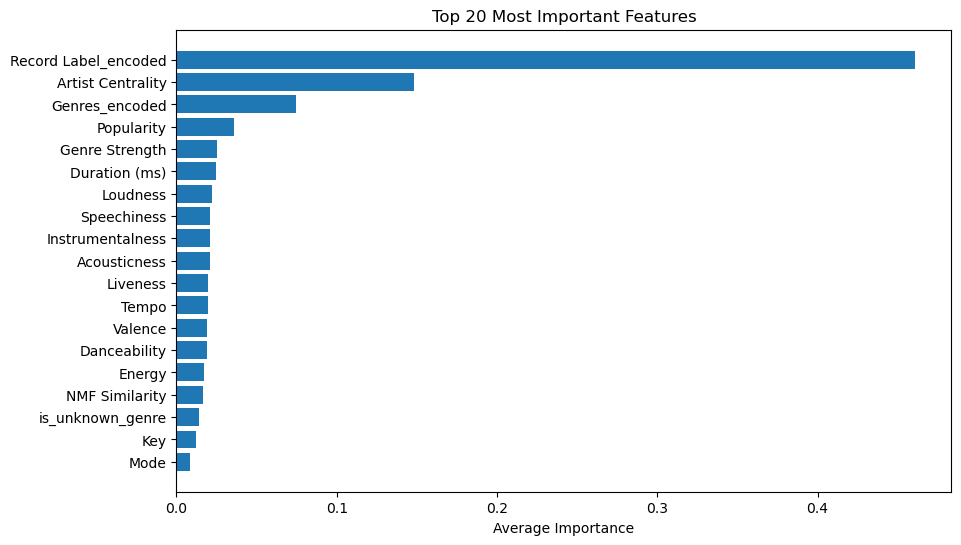

In [75]:
# [Previous code until model training remains the same]
features = [
    'Duration (ms)', 'Popularity', 'Danceability', 'Energy', 'Key', 
    'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
    'Liveness', 'Valence', 'Tempo', 'Record Label_encoded', 
    'is_unknown_genre', 'Genres_encoded', 'Artist Centrality',
    'NMF Similarity', 'Genre Strength'
]

# Normalize the target variable
y_mean = df['liked'].mean()
y_std = df['liked'].std()
y_normalized = (df['liked'] - y_mean) / y_std

# Prepare training data
X = df[features]
y = y_normalized  # Use normalized target

# Train models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

rf_model.fit(X, y)
xgb_model.fit(X, y)

# Get feature importance from both models
rf_importance = pd.DataFrame({
    'feature': features,
    'importance_rf': rf_model.feature_importances_
}).sort_values('importance_rf', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': features,
    'importance_xgb': xgb_model.feature_importances_
}).sort_values('importance_xgb', ascending=False)

# Combine importance scores
feature_importance = pd.merge(rf_importance, xgb_importance, on='feature')
feature_importance['avg_importance'] = (feature_importance['importance_rf'] + feature_importance['importance_xgb']) / 2
feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

# Prepare NMF data for prediction
df_nmf_cleaned = df_nmf[features]

# Make predictions and denormalize
rf_predictions = rf_model.predict(df_nmf_cleaned) * y_std + y_mean
xgb_predictions = xgb_model.predict(df_nmf_cleaned) * y_std + y_mean

# Combine predictions (ensemble)
final_predictions = (rf_predictions + xgb_predictions) / 2

# Get prediction intervals
def get_prediction_interval(X, model, percentile=95):
    predictions = []
    for estimator in model.estimators_:
        predictions.append(estimator.predict(X) * y_std + y_mean)
    predictions = np.array(predictions)
    lower = np.percentile(predictions, (100-percentile)/2, axis=0)
    upper = np.percentile(predictions, 100-(100-percentile)/2, axis=0)
    return lower, upper

# Calculate prediction intervals
lower_bound, upper_bound = get_prediction_interval(df_nmf_cleaned, rf_model)
df_nmf['predicted_score'] = final_predictions
df_nmf['prediction_lower'] = lower_bound
df_nmf['prediction_upper'] = upper_bound
df_nmf['prediction_uncertainty'] = upper_bound - lower_bound

# Get the most common release date from NMF dataset
nmf_release_date = df_nmf['Release Date'].mode().iloc[0]

# Aggregate by album
album_predictions = df_nmf.groupby('Album Name').agg({
    'Artist Name(s)': 'first',
    'predicted_score': ['mean', 'min', 'max', 'std', 'count'],
    'prediction_uncertainty': 'mean',
    'Genres': 'first',
    'Record Label': 'first',
    'Release Date': 'first'
}).reset_index()

# Flatten column names
album_predictions.columns = [
    'Album Name', 'Artist', 
    'avg_score', 'min_score', 'max_score', 'score_std', 'track_count',
    'avg_uncertainty', 'Genres', 'Record Label', 'Release Date'
]

# Calculate confidence score (revised)
max_std = album_predictions['score_std'].max()
max_uncertainty = album_predictions['avg_uncertainty'].max()

album_predictions['confidence_score'] = (
    (1 - album_predictions['score_std'] / max_std) * 
    (1 - album_predictions['avg_uncertainty'] / max_uncertainty) * 
    (1 - 1/(1 + album_predictions['track_count']))
) * 100

# Clip confidence scores to avoid extremely low values
album_predictions['confidence_score'] = np.clip(
    album_predictions['confidence_score'], a_min=1, a_max=100
)

# Add weighted score for ranking
album_predictions['weighted_score'] = (
    album_predictions['avg_score'] * album_predictions['confidence_score'] / 100
)

# Add NMF release date
album_predictions['NMF_Date'] = nmf_release_date

# Sort by weighted score
album_recommendations = album_predictions.sort_values('weighted_score', ascending=False)

# Format the date for the filename
date_str = datetime.strptime(nmf_release_date, '%Y-%m-%d').strftime('%m-%d-%y')
filename = f"{date_str}_Album_Recommendations.csv"

# Create predictions directory if it doesn't exist
os.makedirs('predictions', exist_ok=True)

# Save recommendations to the root predictions folder
album_recommendations.to_csv(f'predictions/{filename}', index=False)

# Sort df_nmf by predicted_score before saving detailed predictions
df_nmf_sorted = df_nmf.sort_values('predicted_score', ascending=False)
df_nmf_sorted[['Artist Name(s)', 'Track Name', 'Album Name', 'predicted_score',
               'prediction_lower', 'prediction_upper', 'prediction_uncertainty']].to_csv(
                   f'predictions/nmf_predictions_with_uncertainty.csv', index=False)

# Print results
print(f"\nNew Music Friday Release Date: {nmf_release_date}")
print("\nTop 10 Recommended Albums:")
print(album_recommendations[['Album Name', 'Artist', 'avg_score', 'track_count', 
                           'confidence_score', 'NMF_Date']].head(10))

# Define the custom scorer for cross-validation
def custom_scorer(y_true, y_pred):
    y_true_denormalized = y_true * y_std + y_mean
    y_pred_denormalized = y_pred * y_std + y_mean
    return -mean_squared_error(y_true_denormalized, y_pred_denormalized)  # Negative MSE for scoring

# Wrap the custom scorer for use with cross_val_score
custom_scorer_func = make_scorer(custom_scorer, greater_is_better=False)

# Evaluate models using cross-validation
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring=custom_scorer_func)
xgb_cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=custom_scorer_func)

# Print cross-validation results
print("\nModel Performance Metrics:")
print(f"Random Forest CV Score: {rf_cv_scores.mean():.3f} (+/- {rf_cv_scores.std() * 2:.3f})")
print(f"XGBoost CV Score: {xgb_cv_scores.mean():.3f} (+/- {xgb_cv_scores.std() * 2:.3f})")

# Print top 20 most important features
print("\nTop 20 Most Important Features:")
print(feature_importance[['feature', 'avg_importance']].head(20).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['avg_importance'])
plt.xlabel('Average Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()